# Random Matrix Theory - Direct diagonalization

We consider an ensemble $\mathcal{M}$ of random matrices $\mathbf{M}$ of dimension $N \times N$ with elements of the form

\begin{equation}
    M_{ij} = A_{i j} J_{i j} = M_{j i}, \tag{1}
\end{equation}

where $\mathbf{A}$ is the adjacency matrix of a Random Regular Graph (RRG) with mean connectivity $c$, and $\mathbf{J}$ is a symmetric random matrix with entries sampled from a Gaussian distribution with mean zero and variance $1/c$.

For elements of this ensemble, we are interested in the spectral density

\begin{equation}
    \rho^{\mathbf{M}}(\lambda) = \frac{1}{N} \sum_{i = 1}^{N} \delta(\lambda - \lambda_{i}^{\mathbf{M}}), \tag{2}
\end{equation}

where $\lambda_{i}^{\mathbf{M}}$ are the eigenvalues of $\mathbf{M}$.

## Algorithm

### Inputs

* Size of the matrix $N$.
* Mean connectivity $c$.

### Outputs

* Eigenvalues $\lambda_{i}^{\mathbf{M}}$ of the realization $\mathbf{M}$.


### Procedure

1. Generate a random regular graph of size $N \times N$ and mean connectivity $c$.
1. Get the adjacency matrix $\mathbf{A}$ from the graph.
1. Define a normal distribution with mean $\mu = 0$ and standard deviation $\sigma = 1/\sqrt{c}$.
1. Define a symmetric $N \times N$ matrix $\mathbf{J}$ and fill its entries with values drawn from the above distribution.
1. Take the element-wise product of $\mathbf{A}$ with $\mathbf{J}$ to obtain $\mathbf{M}$.
1. Compute the eigenvalues of $\mathbf{M}$.

## Displaying $\rho(\lambda)$

From the expression in (2), we can see that $\rho(\lambda)$ consists of a sum of Dirac deltas, which have infinite height at the root of their argument and are zero everywhere else. This can be nicely plotted in a figure of infinite size. Here, however, we will restrain to figures of finite size and do the following instead: 

* The integral of $\rho(\lambda)$ over an interval $a < \lambda < b$ enclosing all the eigenvalues is equal to 1. Therefore, one way to display $\rho(\lambda)$ is to create bins of size $\Delta \lambda$ (not necessarily all of equal size) and make a *normalized* histogram of $\lambda$ vs. $\rho(\lambda)$, where the sum of the bars in the histogram is equal to 1 and the height of each bar represents the integral of $\rho(\lambda)$ along that interval.

## 1. Load packages and define functions

In [1]:
using Distributions  # Define normal distributions with given mean and standard deviation.
using Random  # Generate random numbers from given distributions.
using LightGraphs  # Generate Random Regular Graphs (in particular, adjacency matrices).
using LinearAlgebra  # Compute eigenvalues.
using Plots


# Generate matrix from ensemble.
function make_matrix(N, c; μ=0, σ=1/sqrt(c))
    
    graph = random_regular_graph(N, c)
    A = adjacency_matrix(graph)
    
    d = Normal(μ, σ)
    J = Symmetric(rand(d, (N, N)))
    
    M = Symmetric(A .* J)
    
    return M
end


# Accumulated spectrum of matrices of the ensemble M.
function get_spectrum(N::Int, c::Int, samples::Int; μ=0, σ=sqrt(1/c))
    
    λs = Float64[]  # Store the eigenvalues of each matrix
    
    for _ in 1:samples
        M = make_matrix(N, c, μ=μ, σ=σ) 
        append!(λs, eigvals(M))
    end
    
    return λs
end


# Wrapper function to make the histogram.
function make_histogram(λ_values; 
                        with_wigner=false, 
                        bins=50, histo_color=:aqua, histo_alpha=0.45)
    
    # Binning for the histogram.
    λ_max = maximum(abs.(λ_values))
    b_range = range(-λ_max, λ_max, length=bins+1)
    
    # Make histogram.
    histo = histogram(λ_vals, label=false, 
                      bins=b_range, normalize=:pdf, 
                      color=histo_color, alpha=histo_alpha)
    
    
    # Plot Wigner's semi-circle law.
    if with_wigner
        λ_range = range(-2., 2., length=500)
        plot!(λ_range, sqrt.(4 .- λ_range.^2)/(2*π), 
              lc=:blue, lw=2.4, label=false)
    end
    
    # x-axis ticks.
    xticks_max = round(Int, λ_max)
    xticks_range = -xticks_max:xticks_max
    xticks_label = ["\$ $(i)\$" for i ∈ xticks_range]
    plot!(xticks=(xticks_range, xticks_label))
    
    # y-axis ticks
    bar_heights = [y for y in histo.series_list[1].plotattributes[:y] if !isnan(y)]
    y_max = maximum(bar_heights)
    yticks_range = [y for y in 0:0.1:1 if y <= 1.05*y_max]
    
    # Avoid saturating with many ticks.

    max_yticks = 6

    if length(yticks_range) > max_yticks
        yticks_max = maximum(yticks_range)
        yticks_range = range(0, yticks_max, length=max_yticks)
    end
    
    plot!(yminorticks=2)
    
    yticks_label = ["\$ $(round(y, digits=2)) \$" for y in yticks_range]
    plot!(yticks=(yticks_range, yticks_label))
    
    return histo
end

make_histogram (generic function with 1 method)

## 2. Generate data

In [2]:
Random.seed!(42)  # Fix the seed of every call to random numbers.

N = 2^10  # Linear size of the matrix
c = 3  # Mean connectivity.
samples = 10  # Number of matrices M to be generated.

λ_vals = get_spectrum(N, c, samples);

## 3. Make plot

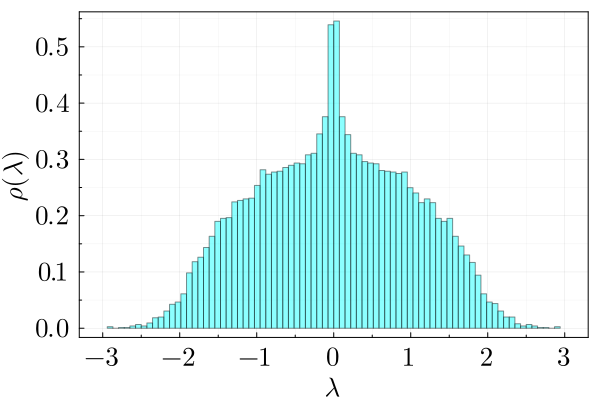

In [4]:
# Plot options.
save_figure = false
with_wigner = false  # Plot Wigner's semi-circle law.


###########################
# General plot attributes #
###########################

kw = (; 
        xlabel="\$ \\lambda \$",
        xminorgrid=true,
        xminorticks=2,
        xlabelfontsize=18,
    
        ylabel="\$ \\rho(\\lambda) \$",
        yminorgrid=true,
        yminorticks=2,
        ylabelfontsize=18,
    
        tickfontsize=18,
    
        framestyle=:box,
        size=(600, 400),
        dpi=400)


my_histo = make_histogram(λ_vals; bins=80, with_wigner=with_wigner)

# Fix ranges for uniform display.
# plot!(xrange=(-2.5, 2.5))
# plot!(yrange=(-0.01, 0.37))

plot!(;kw...)

if ! save_figure
    my_histo
else
    params_end = "_N_$(N)_c_$(c)_samples_$(samples).png"
    file_name = (with_wigner) ? "2_1_histo_wigner" : "2_1_histo"
    savefig(my_histo, "./Figures/" * file_name * params_end)
end